### 训练流程总览

![](md-img/CNN-MNIST.png)

模型详细设置如下：

- 图像的形状：1 * 28 * 28

- 卷积核形状：30 * 1 * 5 * 5

- 卷积计算参数：stride = 1，padding = 0

- 卷积后得到数据形状：30 * 24 * 24

- 池化窗口形状：2 * 2

- 池化计算参数：stride = 2，padding = 0

- 池化后得到数据形状：30 * 12 * 12

- 对数据进行拉平得到形状：4320

- 第一个全连接层输入层与输出层神经元数量：4320 --> 100

- 第二个全连接层输入层与输出层神经元数量：100 --> 10

`softmax 在CrossEntropyLoss层中有，不必额外添加一层`

<br>

### 数据预处理

- 将数据集分为训练集和测试集两部分

- 分别提取数据的特征与标签

- 将特征部分处理成 N * C * H * W 形式的批量图像数据（tensor）并进行归一化操作

- 将标签用 0 ~ M 进行表示（有 M 个类别的分类问题）

- 分别为训练集和测试集创建 Dataset 类和 DataLoader 类供后面使用

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

In [3]:
data = pd.read_csv('dataset/mnist.csv')
print(data.shape)
data.head()

(10000, 785)


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# 将数据集随机分成训练集和测试集
data = data.values
index = np.arange(data.shape[0])
np.random.shuffle(index)
split_ratio = 0.8
split_index = int(split_ratio * data.shape[0])
train_data = data[index[:split_index]]
test_data = data[index[split_index:]]
train_data.shape, test_data.shape

((8000, 785), (2000, 785))

In [5]:
# 分离特征与标签
train_x = train_data[:, 1:]
train_y = train_data[:, 0]
test_x = test_data[:, 1:]
test_y = test_data[:, 0]

In [6]:
# 将特征部分数据转换成 N * C * H * W 形式，并进行归一化操作
train_x = torch.tensor(train_x.reshape(8000, 1, 28, 28), dtype=torch.float32) / 255.0
test_x = torch.tensor(test_x.reshape(2000, 1, 28, 28), dtype=torch.float32) / 255.0
train_y = torch.tensor(train_y)
test_y = torch.tensor(test_y)

In [7]:
# 为训练集和测试集创建 Dataset 和 DataLoader 类
class MNISTDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.x.shape[0]
    

train_dataset = MNISTDataset(train_x, train_y)
test_dataset = MNISTDataset(test_x, test_y)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=100, shuffle=True)

<br>

### 模型框架搭建

In [8]:
from torch import nn

In [9]:
class CNN_MNIST(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(1, 30, 5, 1, 0),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Flatten(),
            nn.Linear(4320, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

<br>

### 神经网络训练

In [10]:
# 指定损失函数
loss_func = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    loss_func = loss_func.cuda()   # 使用 GPU 计算

# 损失函数一般不放在模型框架里面
# 它只是训练的指标，不是模型的一部分

In [11]:
# 优化器的设定
mnist_model = CNN_MNIST()
if torch.cuda.is_available():
    mnist_model = mnist_model.cuda()   # 使用 GPU 计算

learning_rate = 1e-1
optimizer = torch.optim.SGD(mnist_model.parameters(), learning_rate)

In [12]:
# 使用 mini-batch 来训练模型（优化模型参数）
epoch = 125     # 训练轮次


# 用于保存训练过程中训练集和测试集上损失的变化
train_loss_history = []
test_loss_history = []


for i in range(epoch):
    # 将模型设置为训练模式
    mnist_model.train()

    # 每一个 epoch 都会对整个训练集中的数据进行一次应用
    for imgs, labels in train_dataloader:
        # 使用 GPU 计算
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()

        output = mnist_model(imgs)          # 模型正向传播
        loss = loss_func(output, labels)    # 计算损失

        optimizer.zero_grad()    # 清空前面计算的梯度
        loss.backward()          # 反向传播获取梯度
        optimizer.step()         # 应用梯度进行一次参数更新

    # 将模型设置为测试模式
    mnist_model.eval()

    # 每一轮训练结束后，保存当前模型在训练集和测试集上的损失
    # 可以观测模型训练的过拟合情况
    train_loss = 0
    test_loss = 0

    with torch.no_grad():    # 这个部分是测试当前模型，正向传播不需要用于计算梯度
        for imgs, labels in train_dataloader:
            # 使用 GPU 计算
            if torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            output = mnist_model(imgs)
            train_loss = train_loss + loss_func(output, labels).item()
        
        for imgs, labels in test_dataloader:
            # 使用 GPU 计算
            if torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
                
            output = mnist_model(imgs)
            test_loss = test_loss + loss_func(output, labels).item()

    train_loss_history.append(train_loss / len(train_dataloader))
    test_loss_history.append(test_loss / len(test_dataloader))

由于神经网络中某些层在训练和测试时的运行形式不一致（Dropout、BatchNorm）

需要通过 `mnist_model.train()` 和 `mnist_model.eval()` 函数来切换训练和测试状态

<br>

### 绘制损失变化曲线

In [13]:
import matplotlib.pyplot as plt

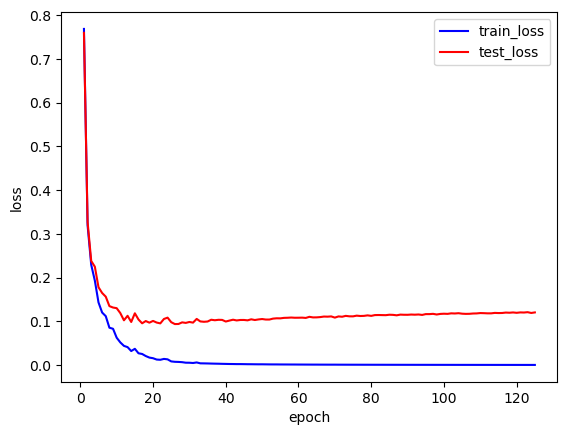

In [14]:
# 横坐标：训练轮次
x = np.arange(1, 126)

plt.plot(x, train_loss_history, label='train_loss', color='blue')
plt.plot(x, test_loss_history, label='test_loss', color='red')

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend()
plt.show()

<br>

### 保存模型

In [16]:
torch.save(mnist_model.state_dict(), 'models/mnist_model.pth')

<br>

### 模型加载与应用

In [17]:
# 加载
state_dict = torch.load('models/mnist_model.pth')
model = CNN_MNIST()
model.load_state_dict(state_dict)

<All keys matched successfully>

In [18]:
# 计算模型在训练集和测试集上的准确率
train_true = 0
test_true = 0

mnist_model.eval()
with torch.no_grad():
    for imgs, labels in train_dataloader:
        # 使用 GPU 计算
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()

        output = mnist_model(imgs) 
        train_true = train_true + (output.argmax(dim=1) == labels).sum().item()
    for imgs, labels in test_dataloader:
        # 使用 GPU 计算
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()

        output = mnist_model(imgs) 
        test_true = test_true + (output.argmax(dim=1) == labels).sum().item()

train_accuracy = train_true / len(train_dataset)
test_accuracy = test_true / len(test_dataset)

print('训练集识别精度为：{}%'.format(train_accuracy * 100))
print('测试集识别精度为：{}%'.format(test_accuracy * 100))

训练集识别精度为：100.0%
测试集识别精度为：97.45%
